In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

Pretty much is a combination of burgers and poisson 

In [72]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

Generalised function for the pressure, noting that all we need to do is change the value of b from the poisson notepad. Hence, all is needed extra is a b generator.

In [73]:
def b_generator(b, rho, dt, u, v, dx, dy):
  first_term = 1/dt * ((u[1:-1,2:] - u[1:-1,0:-2])/(2*dx) + (v[2:,1:-1] - v[0:-2,1:-1])/(2*dy))
  second_term = - ((u[1:-1,2:] - u[1:-1,0:-2])/(2*dx)) * ((u[1:-1,2:] - u[1:-1,0:-2])/(2*dx))
  third_term = -2 * ((v[1:-1,2:] - v[1:-1,0:-2])/(2*dx)) * ((u[2:,1:-1] - u[0:-2,1:-1])/(2*dy))
  fourth_term = - (v[2:,1:-1] - v[0:-2,1:-1])/(2*dy) * (v[2:,1:-1] - v[0:-2,1:-1])/(2*dy)

  b[1:-1, 1:-1] = first_term + second_term + third_term + fourth_term

  return b 

In [74]:
def poisson(p, dx, dy, b, tol=1e-5):
  norm = 1
  while norm > tol:
    p_copy = p.copy()

    p[1:-1,1:-1] = ((dy**2 * (p_copy[1:-1,2:] + p_copy[1:-1,0:-2])) + 
                    (dx**2 * (p_copy[2:,1:-1] + p_copy[0:-2,1:-1]) - 
                     (b[1:-1,1:-1]* dx**2 * dy**2) )) / (2*(dx**2 + dy**2))
    
    p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
    p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
    p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
    p[-1, :] = 0        # p = 0 at y = 2

    norm = (np.sum(np.abs(p[:]) - np.abs(p_copy[:])) /
                np.sum(np.abs(p_copy[:])))   
  return p 

In [75]:
def update_u(u, u_copy, v_copy, p, dt, dx, dy, rho, nu):
  first_term = u_copy[1:-1,1:-1]
  second_term = -u_copy[1:-1,1:-1]*(dt/dx)*(u_copy[1:-1,1:-1]-u_copy[1:-1,0:-2])
  third_term = -v_copy[1:-1,1:-1]*(dt/dy)*(u_copy[1:-1,1:-1]-u_copy[0:-2,1:-1])
  fourth_term = -(dt/(2*rho*dx))*(p[1:-1,2:]-p[1:-1,0:-2])
  fifth_term = nu*((dt/dx**2) * (u_copy[1:-1,2:] - 2*u_copy[1:-1,1:-1] + u_copy[1:-1,0:-2]) + 
                   (dt/dy**2) * (u_copy[2:,1:-1] - 2*u_copy[1:-1,1:-1] + u_copy[0:-2,1:-1]) )
  

  u[1:-1,1:-1] = first_term + second_term + third_term + fourth_term + fifth_term 

  return u

In [76]:
def update_v(v, u_copy, v_copy, p, dt, dx, dy, rho, nu):
  first_term = v_copy[1:-1, 1:-1]
  second_term = -u_copy[1:-1, 1:-1] * dt / dx * (v_copy[1:-1, 1:-1] - v_copy[1:-1, 0:-2])
  third_term = -v_copy[1:-1, 1:-1] * dt / dy * (v_copy[1:-1, 1:-1] - v_copy[0:-2, 1:-1])
  fourth_term = -dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1])
  fifth_term = nu * (dt / dx**2 * (v_copy[1:-1, 2:] - 2 * v_copy[1:-1, 1:-1] + v_copy[1:-1, 0:-2]) +
                  dt / dy**2 * (v_copy[2:, 1:-1] - 2 * v_copy[1:-1, 1:-1] + v_copy[0:-2, 1:-1]) )
  
  v[1:-1,1:-1] = first_term + second_term + third_term + fourth_term + fifth_term 

  return v

In [77]:
def cavity_flow(epochs, u, v, dt, dx, dy, p, rho, nu):
  b = np.zeros((ny,nx))

  for _ in range(epochs):
    un = u.copy()
    vn = v.copy()

    b = b_generator(b, rho, dt, u, v, dx, dy)
    p = poisson(p, dx, dy, b)
    
    u = update_u(u, un, vn, p, dt, dx, dy, rho, nu)

    v = update_v(v, un, vn, p, dt, dx, dy, rho, nu)


    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0
    u[-1, :] = 1    # set velocity on cavity lid equal to 1
    v[0, :]  = 0
    v[-1, :] = 0
    v[:, 0]  = 0
    v[:, -1] = 0

  return u, v, p



In [78]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 100
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


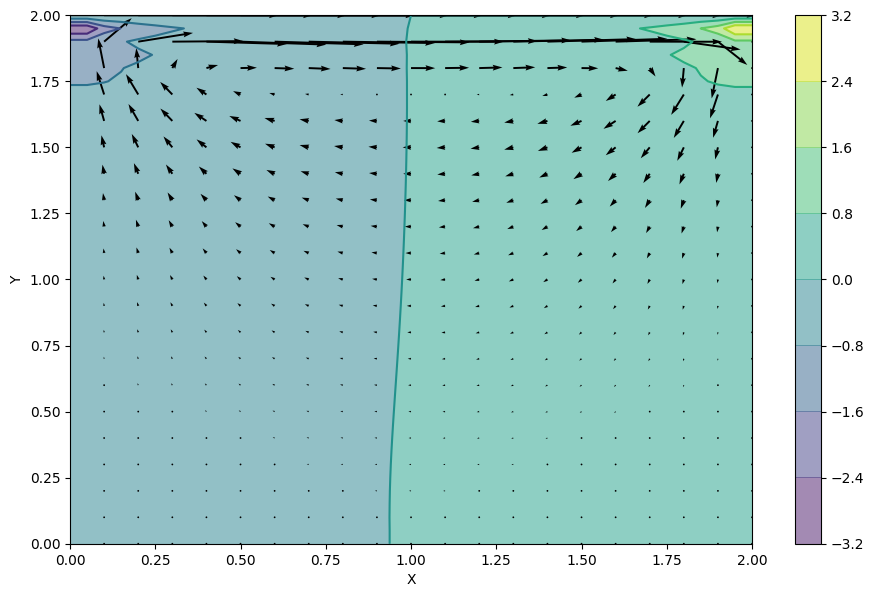

In [79]:
fig = plt.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
plt.colorbar()
# plotting the pressure field outlines
plt.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
plt.xlabel('X')
plt.ylabel('Y');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


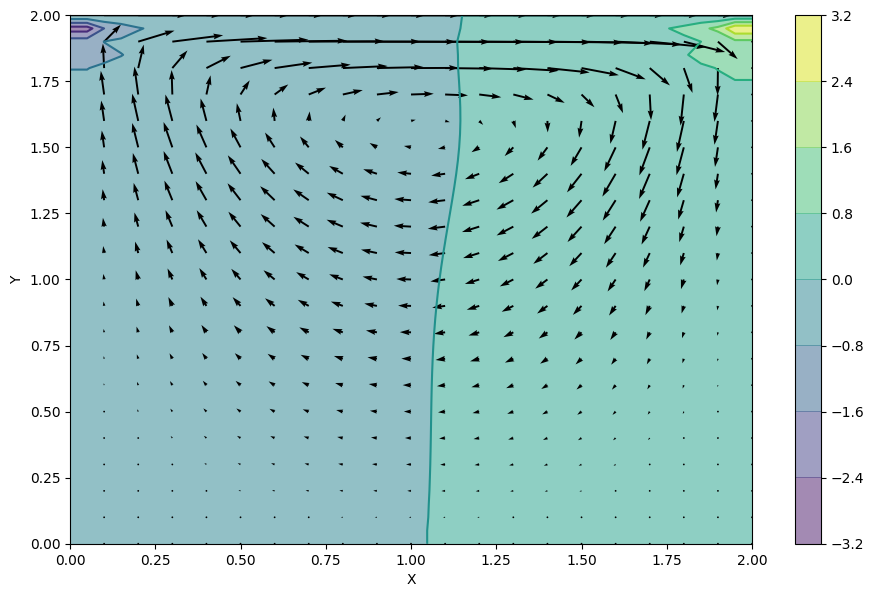

In [80]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

fig = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
plt.colorbar()
plt.contour(X, Y, p, cmap=cm.viridis)
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
plt.xlabel('X')
plt.ylabel('Y');

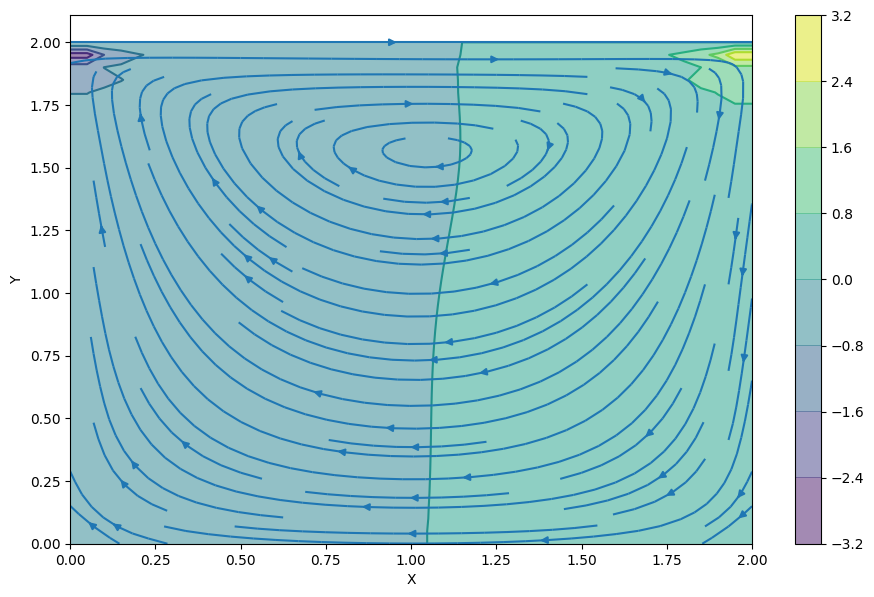

In [81]:
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
plt.colorbar()
plt.contour(X, Y, p, cmap=cm.viridis)
plt.streamplot(X, Y, u, v)
plt.xlabel('X')
plt.ylabel('Y');